# データの読み込み

In [32]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import sklearn.preprocessing as sp
from sklearn.preprocessing import LabelEncoder

In [34]:
df_train = pd.read_csv('./House Price/train.csv', index_col="Id")
df_test = pd.read_csv('./House Price/test.csv', index_col="Id")

# 外れ値の除外
## 価格と面積の相関
同じ地域の不動産なら面積に比例して価格も高くなるはず

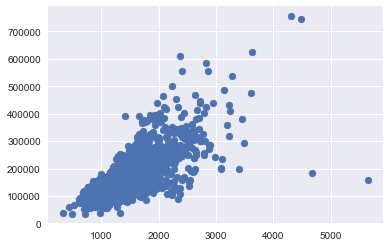

In [35]:
plt.scatter(df_train.GrLivArea, df_train.SalePrice)

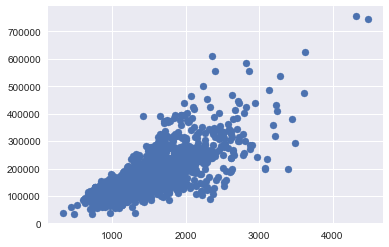

In [36]:
# 面積が4000以上で価格が200000以下は外れ値として取り除く
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]
# 除外後の相関を確認
plt.scatter(df_train.GrLivArea, df_train.SalePrice)

In [37]:
#Id及びSaleprice以外の全データを結合(左端=Id, 右端はSalePrice)
# 'MSSubClass'(1列目(id除く))から'SaleCondition'(SalePriceの手前)まで
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))

# 多重共線性の確認

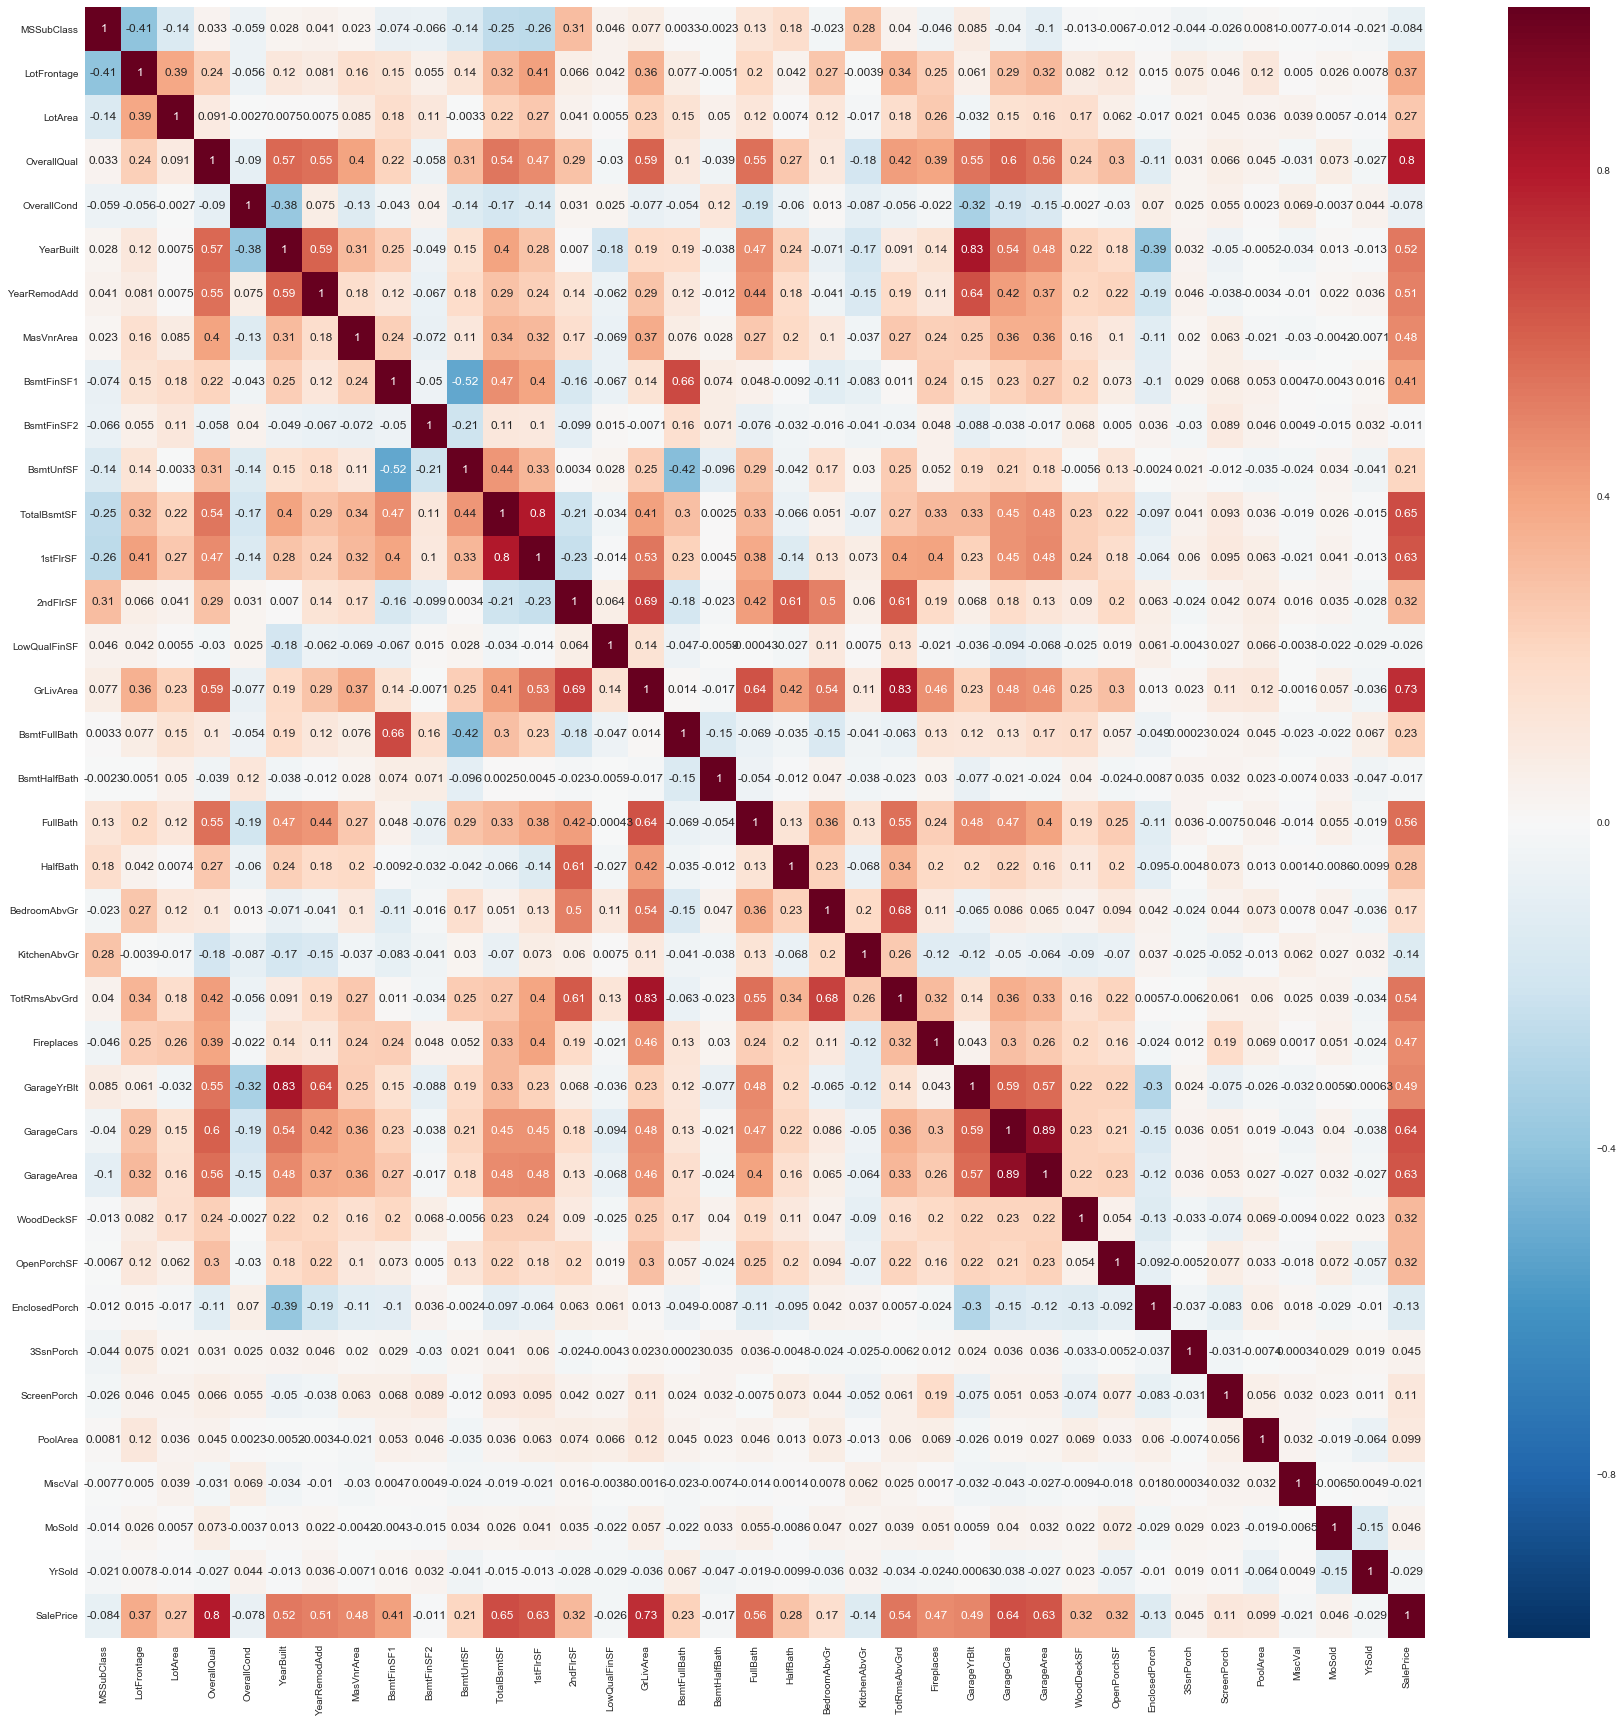

In [6]:
#相関係数行列の可視化
# 行１列１、縦横30インチの箱を用意する
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
# seabornのheatmapを作成
# df_train.corr(): トレーニングデータの相関係数
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [38]:
# 高速版
# dataframe.iterでループさせるのではなくnumpy.arrayで高速にループさせる
# 相関係数が絶対値で0.8を超えているものはほぼ確実に多重共線性を引き起こすので、
# 特徴量から削除します。
indexs = df_train.corr().index
cols = []
row_count = 0
for row in df_train.corr().values:
    col_count = 0
    for col in row:
        # 列と行が同じindexの場合は次の行へ
        if row_count == col_count:
            break
        # SalePriceは目的変数なので削除しない
        if indexs[row_count] == "SalePrice":
            break
        # 多重共線性の絶対値が0.8以上のindex
        if abs(col) > 0.8:
            cols.append(indexs[row_count])
            # breakしないと同じindexが何度も取得される
            break
        col_count+=1
    row_count+=1

print(cols)
df_all.drop(cols, axis=1, inplace=True)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


In [23]:
# 相関係数が絶対値で0.8を超えているものはほぼ確実に多重共線性を引き起こすので、
# 特徴量から削除します。

cols = []
for index, row in df_train.corr().iterrows():
    for index2, value in row.iteritems():
        # 列と行が同じindexの場合は次の行へ
        if index==index2:
            break
        # SalePriceは目的変数なので削除しない
        if index=="SalePrice":
            break
        # 多重共線性の絶対値が0.8以上のindex
        if abs(value) > 0.5:
            cols.append(index) 

print(cols)
df_all.drop(cols, axis=1, inplace=True)

['YearBuilt', 'YearRemodAdd', 'YearRemodAdd', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GrLivArea', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'BedroomAbvGr', 'TotRmsAbvGrd', 'TotRmsAbvGrd', 'TotRmsAbvGrd', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageYrBlt', 'GarageYrBlt', 'GarageCars', 'GarageCars', 'GarageCars', 'GarageArea', 'GarageArea', 'GarageArea']


# 説明変数・目的変数の分布の正規化

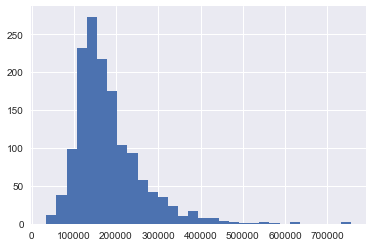

In [39]:
# SalePriceのヒストグラム
# bins:ビン数(表示する棒の数、デフォルトは10)
df_train["SalePrice"].hist(bins=30)

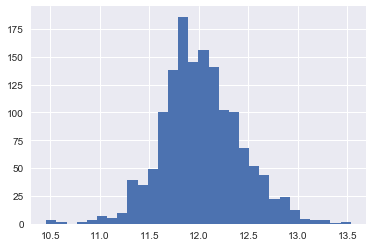

In [40]:
# 高いほうに向かって裾野が広い分布は、対数変換をかけてやる
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [41]:
#カテゴリカルでない特徴量
# dtype一覧は<https://note.nkmk.me/python-pandas-dtype-astype/>を参照
# object以外は数値、bool, 複素数
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
# ここがよくわからない
# lambda式 lambda 引数:処理内容
# skew:データセットの歪度の計算
# apply:DataFrameの軸に沿って適用
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
#print(skewed_feats > 0.6)
skewed_feats = skewed_feats[skewed_feats > 0.6].index
#歪度0.6より大きい特徴量を対数変換
df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

# One Hot Encodingと欠損値の穴埋め

In [49]:
#欠損値を平均値で補完
df_all = df_all.fillna(df_all.mean())

# カテゴリカル変数のリスを作成する
categoricals = df_all.dtypes[df_all.dtypes == 'object'].index
categoricals_list = []
for index in categoricals:
    categoricals_list.append(index)
    
# ラベルエンコードとOneHotEncodingを一列ずつ実施する
lbl = LabelEncoder()
ohe = OneHotEncoder(sparse = True)
nan_columns = []
for col in categoricals_list:
    # print(col)
    lbl.fit(list(df_all[col].values.astype('str')))
    df_all[col] = lbl.transform(df_all[col].values.astype('str'))
    # .values: dataframeのindexなしで配列で返す(1次元配列)
    # reshape(1, -1): 2次元配列に変換している(1行n列)
    # transpose(): 行と列を入れ替える(n行1列)
    # fit_transformからfitとtransformに分ける
    # やっていることは同じだが、fit_transformではtransform前の情報を保持できない
    # transform前の情報が必要になることがある
    # 必要になるときは ??? など
    #enced = ohe.fit_transform(df_all[col].values.reshape(1,-1).transpose())
    ohe.fit(df_all[col].values.reshape(1,-1).transpose())
    enced = ohe.transform(df_all[col].values.reshape(1,-1).transpose())
    column_names = []
    for cls in lbl.classes_:
        new_column_name = col + "_" + cls
        column_names.append(new_column_name)
        if cls == "nan":
            nan_columns.append(new_column_name)
    temp = pd.DataFrame(index=df_all.index, columns =column_names, data=enced.toarray())
    df_all = pd.concat([df_all, temp], axis=1)
    del df_all[col]
    
# 欠損値の列(_nan)を削除
# delでは複数列を削除できない
#del data[nan_columns]
df_all.drop(nan_columns, axis=1, inplace=True)

# Lassoのハイパーパラメータの最適値を求める

In [178]:
#学習データ、テストデータに分割
# X: df_allの1行目からdf_trainの行数目まで(トレーニングデータセット部分)
X = df_all[:df_train.shape[0]]
# X_for_test: df_trainの行数目+1から最終行まで(テストデータセット部分)
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [184]:
best_rmse = 1
for num in range (1, 100):
    alpha = num*0.00001
    reg = Lasso(alpha=alpha, max_iter=3000)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    if best_rmse > rmse :
        best_rmse = rmse
        best_alpha = alpha
        
print("alpha:", best_alpha,", ラッソ回帰でのRMSE:", best_rmse)

alpha: 0.00055 , ラッソ回帰でのRMSE: 0.114252193916


# Lassoの適用

In [185]:
# 最適値を適用
reg = Lasso(alpha=best_alpha)
# 全データで学習
reg.fit(X,y)

Lasso(alpha=0.00055, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [186]:
# 対数変換をしたのでexpをとる
pred = np.expm1(reg.predict(X_for_test))

In [187]:
solution = pd.DataFrame({"id":df_test.index, "SalePrice":pred})
solution.to_csv("test_lasso.csv", index = False)

# おまけ

In [188]:
# .coef_:回帰変数?とは何？
coef = pd.Series(reg.coef_, index = X_train.columns)
print(coef)

MSSubClass               0.000000
LotFrontage              0.006685
LotArea                  0.082565
OverallQual              0.052921
OverallCond              0.257623
YearBuilt                0.001641
YearRemodAdd             0.001000
MasVnrArea              -0.000000
BsmtFinSF1               0.009124
BsmtFinSF2              -0.002771
BsmtUnfSF               -0.005735
TotalBsmtSF              0.000128
2ndFlrSF                 0.000582
LowQualFinSF            -0.002482
GrLivArea                0.383053
BsmtFullBath             0.023145
BsmtHalfBath             0.000000
FullBath                 0.017296
HalfBath                 0.024169
BedroomAbvGr            -0.003685
KitchenAbvGr            -0.000000
Fireplaces               0.031330
GarageCars               0.046130
WoodDeckSF               0.004554
OpenPorchSF              0.001303
EnclosedPorch            0.002242
3SsnPorch                0.000799
ScreenPorch              0.007996
PoolArea                 0.019182
MiscVal       

In [189]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 93 variables and eliminated the other 190 variables


# Lasso2週目

In [191]:
# ゼロの列を削除する
ZeroIndex = coef[coef == 0].index
df_all.drop(ZeroIndex, axis=1, inplace=True)
df_all.shape

(2917, 93)

In [192]:
#学習データ、テストデータに分割
# X: df_allの1行目からdf_trainの行数目まで(トレーニングデータセット部分)
X = df_all[:df_train.shape[0]]
# X_for_test: df_trainの行数目+1から最終行まで(テストデータセット部分)
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [193]:
best_rmse = 1
for num in range (1, 1000):
    alpha = num*0.00001
    reg = Lasso(alpha=alpha, max_iter=3000)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    if best_rmse > rmse :
        best_rmse = rmse
        best_alpha = alpha
        
print("alpha:", best_alpha,", ラッソ回帰でのRMSE:", best_rmse)

alpha: 0.00038 , ラッソ回帰でのRMSE: 0.112625246483


1回目のテストデータでの結果が「RMSE: 0.114252193916」なので若干よくなっている

In [195]:
# 最適値を適用
reg = Lasso(alpha=best_alpha)
# 全データで学習
reg.fit(X,y)

Lasso(alpha=0.00038, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [196]:
# 対数変換をしたのでexpをとる
pred = np.expm1(reg.predict(X_for_test))

In [197]:
solution = pd.DataFrame({"id":df_test.index, "SalePrice":pred})
solution.to_csv("test_lasso_2.csv", index = False)

Score: 0.11708  
スコアは初回が0.11703だったので若干悪くなる

# Lasso 3週目

In [198]:
coef = pd.Series(reg.coef_, index = X_train.columns)
# ゼロの列を削除する
ZeroIndex = coef[coef == 0].index
df_all.drop(ZeroIndex, axis=1, inplace=True)
df_all.shape

(2917, 92)

一つしか変数が落ちていない

In [199]:
#学習データ、テストデータに分割
# X: df_allの1行目からdf_trainの行数目まで(トレーニングデータセット部分)
X = df_all[:df_train.shape[0]]
# X_for_test: df_trainの行数目+1から最終行まで(テストデータセット部分)
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [200]:
best_rmse = 1
for num in range (1, 1000):
    alpha = num*0.00001
    reg = Lasso(alpha=alpha, max_iter=3000)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    if best_rmse > rmse :
        best_rmse = rmse
        best_alpha = alpha
        
print("alpha:", best_alpha,", ラッソ回帰でのRMSE:", best_rmse)

alpha: 0.00042 , ラッソ回帰でのRMSE: 0.112520805377


2回目のテストデータの結果が「RMSE: 0.112625246483」だったので若干よくなった

In [201]:
# 最適値を適用
reg = Lasso(alpha=best_alpha)
# 全データで学習
reg.fit(X,y)

Lasso(alpha=0.00042, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [202]:
# 対数変換をしたのでexpをとる
pred = np.expm1(reg.predict(X_for_test))

In [203]:
solution = pd.DataFrame({"id":df_test.index, "SalePrice":pred})
solution.to_csv("test_lasso_3.csv", index = False)

Score: 0.11703  
1回目と全く同じスコア(2回目より若干よくなった)

# Lasso 4週目

In [53]:
coef = pd.Series(reg.coef_, index = X_train.columns)
ZeroIndex = coef[coef == 0].index
print(ZeroIndex)

Index([], dtype='object')


0になった説明変数がなかった。  
House Priceの問題で有効な変数は以下の通り

In [54]:
coef

LotFrontage              8.930134e-03
LotArea                  8.316417e-02
OverallQual              5.086162e-02
OverallCond              2.623117e-01
YearBuilt                1.609842e-03
YearRemodAdd             9.538926e-04
BsmtFinSF1               8.971196e-03
BsmtFinSF2              -2.773373e-03
BsmtUnfSF               -5.625553e-03
TotalBsmtSF              1.241200e-04
LowQualFinSF            -3.269690e-03
GrLivArea                3.886818e-01
BsmtFullBath             2.382316e-02
FullBath                 1.953980e-02
HalfBath                 2.723681e-02
BedroomAbvGr            -3.960920e-03
Fireplaces               3.135039e-02
GarageCars               4.569496e-02
WoodDeckSF               4.531046e-03
OpenPorchSF              1.158124e-03
EnclosedPorch            2.097743e-03
3SsnPorch                9.764782e-04
ScreenPorch              7.953636e-03
PoolArea                 2.044325e-02
MiscVal                 -2.386839e-03
MoSold                  -3.584850e-04
YrSold      

0になったのがないので平均以下を除外してみる

In [58]:
from statistics import mean, median,variance,stdev
average = mean(coef)
BelowAverageIndex = coef[coef < average].index
print(BelowAverageIndex)

Index(['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BedroomAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)',
       'MSZoning_RM', 'LotShape_IR1', 'LotConfig_Corner', 'LotConfig_FR2',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel',
       'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Condition1_Artery',
       'Condition1_RRAe', 'BldgType_Duplex', 'Exterior1st_HdBoard',
       'Exterior1st_MetalSd', 'Exterior1st_Wd Sdng', 'Exterior2nd_Plywood',
       'ExterQual_TA', 'ExterCond_TA', 'Foundation_BrkTil', 'BsmtQual_TA',
       'BsmtCond_Fa', 'BsmtExposure_No', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'Heating_Grav', 'HeatingQC_Gd',
       'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'KitchenQual_TA',
       'FireplaceQu_Gd', 'GarageType_BuiltIn', 'Garage

In [59]:
df_all.drop(BelowAverageIndex, axis=1, inplace=True)
df_all.shape

(2917, 34)

In [60]:
#学習データ、テストデータに分割
# X: df_allの1行目からdf_trainの行数目まで(トレーニングデータセット部分)
X = df_all[:df_train.shape[0]]
# X_for_test: df_trainの行数目+1から最終行まで(テストデータセット部分)
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [61]:
best_rmse = 1
for num in range (1, 1000):
    alpha = num*0.00001
    reg = Lasso(alpha=alpha)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    if best_rmse > rmse :
        best_rmse = rmse
        best_alpha = alpha
        
print("alpha:", best_alpha,", ラッソ回帰でのRMSE:", best_rmse)

alpha: 1e-05 , ラッソ回帰でのRMSE: 0.125751946306


In [62]:
# 最適値を適用
reg = Lasso(alpha=best_alpha)
# 全データで学習
reg.fit(X,y)
# 対数変換をしたのでexpをとる
pred = np.expm1(reg.predict(X_for_test))
solution = pd.DataFrame({"id":df_test.index, "SalePrice":pred})
solution.to_csv("test_lasso_4.csv", index = False)

Score: 0.13605  
やはりスコアは悪くなった